In [1]:
using Pkg

In [2]:
Pkg.activate("../")

  Activating project at `~/Julia_learning_repo/Yao_QC_learning/LS_EDF_QC`


In [3]:
using Yao, YaoPlots, Yao.EasyBuild
using LinearAlgebra, Statistics, Random, StatsBase

In [18]:
using Flux:batch, Flux

In [5]:
using Printf, Plots, MAT

In [7]:
gr()

Plots.GRBackend()

In [21]:
include("Layer.jl")
include("Loss_Accuracy.jl")

crossentropy (generic function with 1 method)

# import and visualize the data

In [6]:
vars = matread("/home_2/Datasets/fashion_MNIST/FashionMNIST_1_2_wk.mat")
x_train = vars["x_train"]
y_train = vars["y_train"]
x_test = vars["x_test"]
y_test = vars["y_test"]

2000×2 Matrix{Float64}:
 0.0  1.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 1.0  0.0
 ⋮    
 1.0  0.0
 0.0  1.0
 0.0  1.0
 1.0  0.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 1.0  0.0
 1.0  0.0
 0.0  1.0
 0.0  1.0

In [23]:
num_train = 1000
num_test = 200
x_train = x_train[:,1:num_train]
y_train = y_train[1:num_train,:]
x_test = x_test[:,1:num_test]
y_test = y_test[1:num_test,:];

In [8]:
i = 13
a = real(vars["x_train"][1:256,i])
c1 = reshape(a,(16,16))
i = 6
a = real(vars["x_train"][1:256,i])
c2 = reshape(a,(16,16))

16×16 Matrix{Float64}:
 0.0         0.0          0.0          …  0.000428963  0.0
 0.0         0.0          0.0             0.00343171   0.0
 0.0         0.0          0.0             0.00128689   0.000428963
 0.0         0.0          0.0             0.00128689   0.0
 0.0         0.0          0.0             0.0          0.0
 0.0         0.0          0.0          …  0.000428963  0.0
 0.0         0.0          0.0             0.0          0.0
 0.0         0.0          0.0             0.0287405    0.0
 0.0         0.0          0.0             0.0454701    0.00900823
 0.0         0.0          0.0             0.0          0.0
 0.0         0.0          0.0          …  0.0          0.0
 0.0         0.00128689   0.000428963     0.0          0.0
 0.0         0.0167296    0.0403225       0.000857926  0.0
 0.00557652  0.0973746    0.0990905       0.00171585   0.0
 0.00343171  0.0853637    0.102522        0.00257378   0.0
 0.0         0.000428963  0.0180165    …  0.000428963  0.0

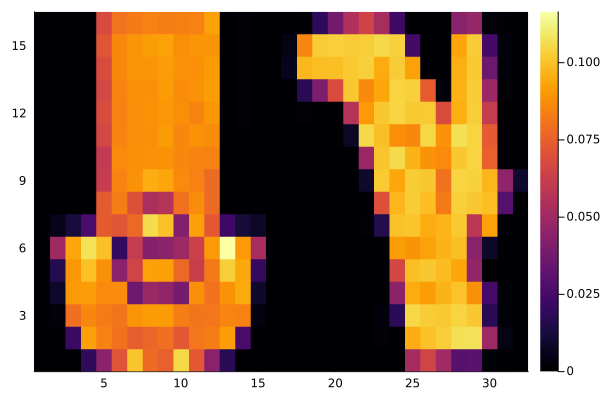

In [17]:
heatmap(hcat(c1,c2))

# hyper-parameter setting

In [19]:
num_qubit = 8    # number of qubits
depth = 10       # number of parameterized composite_blocks
batch_size = 100 # batch size
lr = 0.01        # learning rate
niters = 30;     # number of iterations
optim = Flux.ADAM(lr); # Adam optimizer

In [20]:
# index of qubit that will be measured
pos_ = 8;       
op0 = put(num_qubit, pos_=>0.5*(I2+Z))
op1 = put(num_qubit, pos_=>0.5*(I2-Z));

# put the training and test set into quantum states

In [25]:
x_train_yao = zero_state(num_qubit,nbatch=num_train)
x_train_yao.state = x_train;
cu_x_train_yao = copy(x_train_yao);

In [26]:
x_test_yao = zero_state(num_qubit,nbatch=num_test)
x_test_yao.state  = x_test;
cu_x_test_yao = copy(x_test_yao);

# define the circuit

In [27]:
# define the QNN circuit, some functions have been defined before
ent_layer(nbit::Int64) = ent_cx(nbit)
parameterized_layer(nbit::Int64) = params_layer(nbit)
composite_block(nbit::Int64) = chain(nbit, parameterized_layer(nbit::Int64), ent_layer(nbit::Int64))
circuit = chain(composite_block(num_qubit) for _ in 1:depth)
# assign random initial parameters to the circuit
dispatch!(circuit, :random)
params = parameters(circuit);

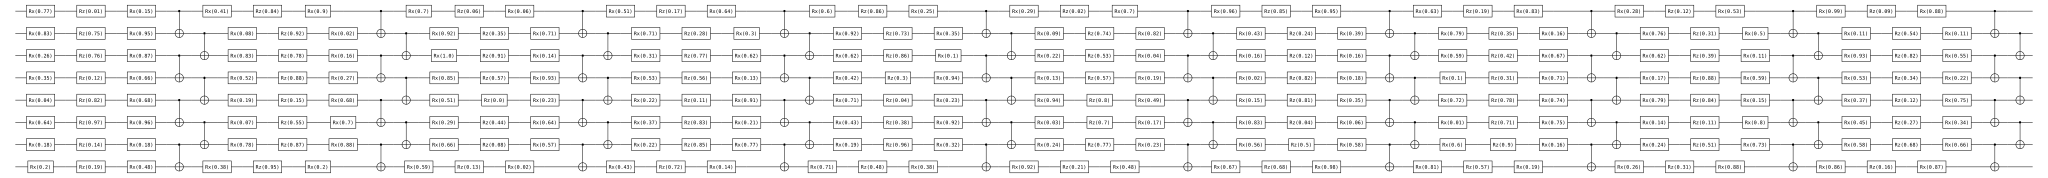

In [28]:
YaoPlots.plot(circuit)

# training

In [29]:
loss_train_history = Float64[]
acc_train_history = Float64[]
loss_test_history = Float64[]
acc_test_history = Float64[];

In [31]:
for k in 0:niters
    # calculate the accuracy & loss for the training & test set
    train_acc, train_loss = acc_loss_evaluation(circuit,cu_x_train_yao,y_train,num_train, pos_)
    test_acc, test_loss = acc_loss_evaluation(circuit,cu_x_test_yao,y_test,num_test, pos_)
    push!(loss_train_history, train_loss)
    push!(loss_test_history, test_loss)
    push!(acc_train_history, train_acc)
    push!(acc_test_history, test_acc)
    if k % 5 == 0
        @printf("\nStep=%d, loss=%.3f, acc=%.3f, test_loss=%.3f,test_acc=%.3f\n",k,train_loss,train_acc,test_loss,test_acc)
    end
    
    # at each training epoch, randomly choose a batch of samples from the training set
    batch_index = randperm(size(x_train)[2])[1:batch_size]
    x_batch = x_train[:,batch_index]
    y_batch = y_train[batch_index,:];
    # prepare these samples into quantum states
    x_batch_1 = copy(x_batch)
    x_batch_yao = zero_state(num_qubit,nbatch=batch_size)
    x_batch_yao.state = x_batch_1;
    cu_x_batch_yao = copy(x_batch_yao);
    batc = [zero_state(num_qubit) for i in 1:batch_size]
    for i in 1:batch_size
        batc[i].state = x_batch_1[:,i:i]
    end
    
    # for all samples in the batch, repeatly measure their qubits at position pos_ 
    # on the computational basis
    q_ = zeros(batch_size,2);
    res = copy(cu_x_train_yao) |> circuit
    for i=1:batch_size
        rdm = density_matrix(viewbatch(res, i), (pos_,))
        q_[i,:] = Yao.probs(rdm)
    end
    
    # calculate the gradients w.r.t. the cross-entropy loss function
    Arr = Array{Float64}(zeros(batch_size,nparameters(circuit)))
    for i in 1:batch_size
        Arr[i,:] = expect'(op0, copy(batc[i])=>circuit)[2]
    end
    C = [Arr, -Arr]
    grads = collect(mean([-sum([y_batch[i,j]*((1 ./ q_)[i,j])*batch(C)[i,:,j] for j in 1:2]) for i=1:batch_size]))
    
    # update the parameters
    updates = Flux.Optimise.update!(optim, params, grads);
    dispatch!(circuit, updates) 
end


Step=0, loss=0.668, acc=0.803, test_loss=0.671,test_acc=0.795

Step=5, loss=0.537, acc=0.995, test_loss=0.536,test_acc=0.995

Step=10, loss=0.471, acc=0.996, test_loss=0.472,test_acc=1.000

Step=15, loss=0.436, acc=0.995, test_loss=0.439,test_acc=0.995

Step=20, loss=0.417, acc=0.997, test_loss=0.420,test_acc=0.995

Step=25, loss=0.400, acc=0.996, test_loss=0.404,test_acc=0.990

Step=30, loss=0.386, acc=0.996, test_loss=0.390,test_acc=0.990


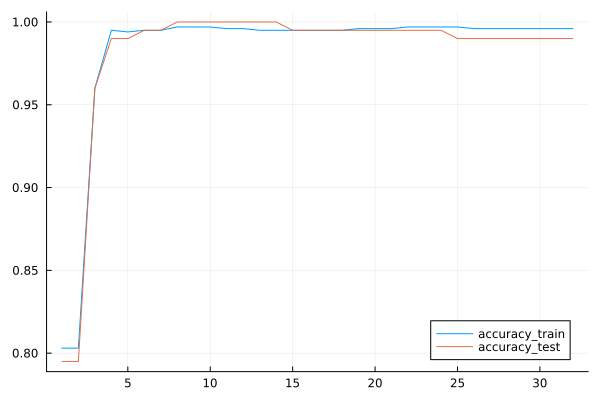

In [32]:
Plots.plot(acc_train_history,label="accuracy_train",legend = :bottomright)
Plots.plot!(acc_test_history,label="accuracy_test",legend = :bottomright)

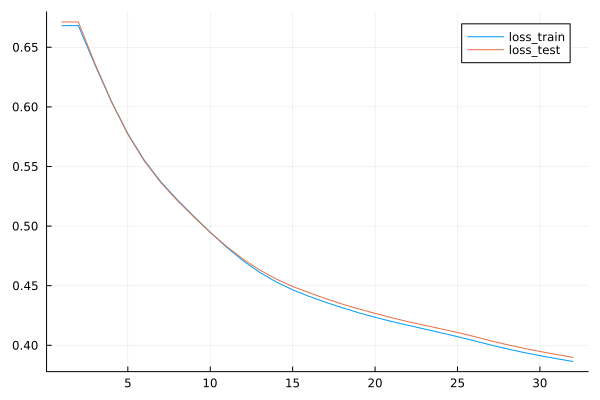

In [33]:
Plots.plot(loss_train_history,label="loss_train")
Plots.plot!(loss_test_history,label="loss_test")